In [1]:

from IPython.display import HTML, Image

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib import animation

import seaborn as sns
import numpy as np
sns.set(rc={"figure.figsize": (10, 10)})

# Break from default darkgrid for better printing on paper
sns.set_style("whitegrid")

# External Includes
import torch
from torch.nn import Sequential, Parameter
from torch.autograd import Variable
from torch.optim import SGD

# Internal Includes
from rfml.ptradio import RRC, Upsample, Downsample
from rfml.ptradio.modem import _qpsk_constellation
from rfml.nn.F import evm

In [2]:
n_symbols = 32

In [3]:
indices = np.random.randint(low=0, high=4, size=n_symbols)
target_symbols = np.array([_qpsk_constellation[i] for i in indices])
target_symbols = np.stack((target_symbols.real, target_symbols.imag))

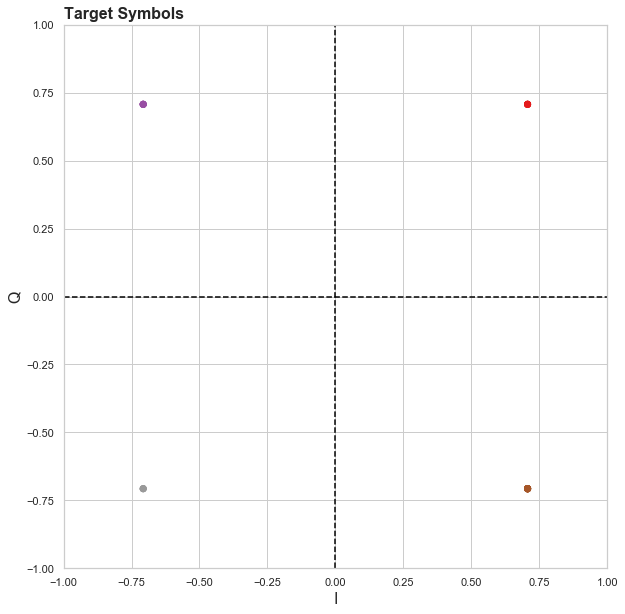

In [4]:
target_symbols.shape

def plotSymbols(ax, symbols, c):
    ax.scatter(symbols[0,:], symbols[1,:], c=c, cmap="Set1")

    plt.axhline(0, ls="--", color="black")
    plt.axvline(0, ls="--", color="black")

    ax.set_xlabel("I", fontsize=16)
    ax.set_ylabel("Q", fontsize=16)
    
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])

    ax.set_aspect("equal", "box")

fig, ax = plt.subplots(1, 1, figsize=(10,10))
plotSymbols(ax, target_symbols, indices)
ax.set_title("Target Symbols", fontsize=16, fontweight="bold", loc="left")
fig.savefig("/Users/bballtwenty8/Downloads/targetsymbols.eps", format="eps", transparent=True)

torch.Size([1, 1, 2, 32])
torch.Size([1, 1, 2, 32])
(32, 2)
(2, 32)
Saving
(32, 2)
(2, 32)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
Saved


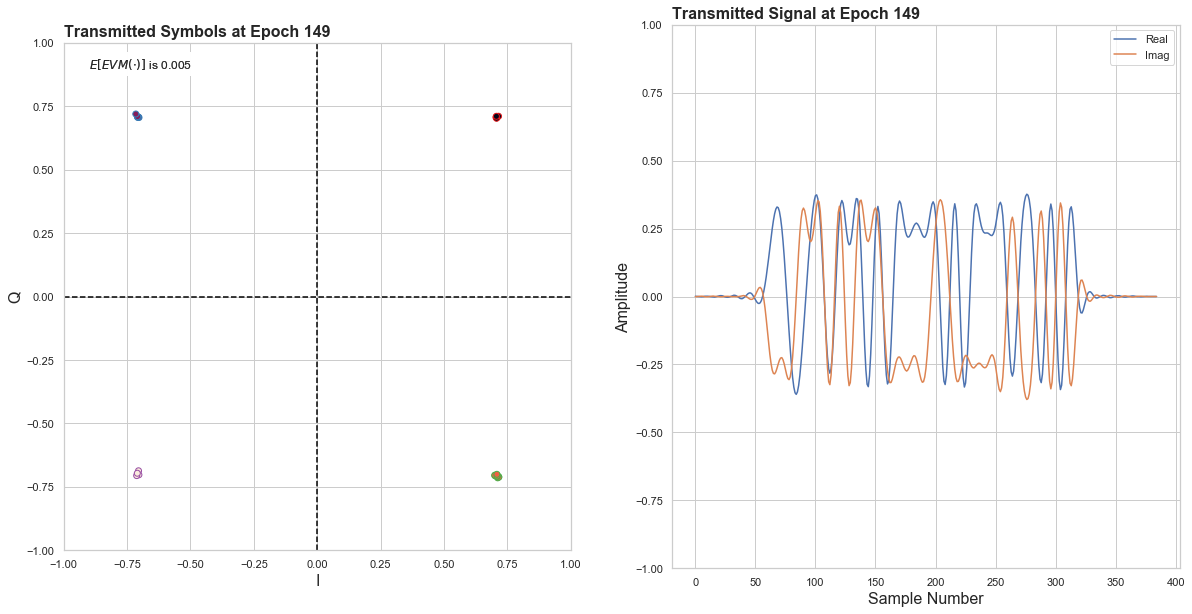

In [12]:
fig, axes = plt.subplots(1,2, figsize=(20,10))

axes[0].axhline(0, ls="--", color="black")
axes[0].axvline(0, ls="--", color="black")

axes[0].set_xlabel("I", fontsize=16)
axes[0].set_ylabel("Q", fontsize=16)

axes[0].set_xlim([-1, 1])
axes[0].set_ylim([-1, 1])

axes[0].set_aspect("equal", "box")

axes[1].set_xlabel("Sample Number", fontsize=16)
axes[1].set_ylabel("Amplitude", fontsize=16)

#axes[1].set_xlim([-1, 1])
axes[1].set_ylim([-1, 1])

#axes[1].set_aspect("equal", "box")

_target_symbols = torch.from_numpy(target_symbols[np.newaxis, np.newaxis,::].astype(np.float32))
print(_target_symbols.shape)

mean = torch.zeros((1, 1, 2, _target_symbols.shape[3]))
std = torch.ones((1, 1, 2, _target_symbols.shape[3]))
tx_symbols = torch.nn.Parameter(torch.normal(mean, std))

optimizer = SGD((tx_symbols,), lr=10e-2, momentum=0.9)

tx_chain = Sequential(Upsample(i=8),
                      RRC(alpha=0.35,
                          sps=8,
                          filter_span=8,
                          add_pad=True))
rx_chain = Sequential(RRC(alpha=0.35,
                          sps=8,
                          filter_span=8,
                          add_pad=False),
                      Downsample(offset=8*8,
                                 d=8))

def symbols_to_numpy(x):
    return x.detach().numpy()[0,0,::].transpose(1, 0)

def init():
    x = symbols_to_numpy(tx_symbols)
    print(x.shape)
    print(x.transpose(1,0).shape)
    scatter.set_offsets(x)
    scatter.set_array(indices)
    return scatter,

def animate(i):
    print(i)
    tx_signal = tx_chain(tx_symbols)
    rx_symbols = rx_chain(tx_signal)
    loss = torch.mean(evm(rx_symbols, _target_symbols))
    #print(loss.item())

    loss.backward()
    optimizer.step()
    tx_symbols.grad.zero_()

    #fig.suptitle(r"$E[EVM(\cdot)]$ = {:.3f}".format(loss.item()), x=0.0, horizontalalignment="left", fontstyle="italic", fontsize=12)
    
    axes[0].set_title("Transmitted Symbols at Epoch {}".format(i), fontweight="bold", fontsize=16, loc="left")
    axes[0].text(s=r"$E[EVM(\cdot)]$ is {:.3f}".format(loss.item()), x=-0.9, y=0.9, fontsize=12,
                 horizontalalignment="left", bbox=dict(facecolor="white", alpha=0.5))
    axes[1].set_title("Transmitted Signal at Epoch {}".format(i), fontweight="bold", fontsize=16, loc="left")

    x = symbols_to_numpy(tx_symbols)
    scatter.set_offsets(x)
    scatter.set_array(indices)
    scatter.set_color(matplotlib.cm.Set1(indices))

    x = symbols_to_numpy(tx_signal)
    lineR.set_data(t, x[:,0])
    lineI.set_data(t, x[:,1])
    
    return scatter,

print(tx_symbols.shape)

x = symbols_to_numpy(tx_symbols)
scatter = axes[0].scatter(x[:,0], x[:,1], cmap="Set1")

x = symbols_to_numpy(tx_chain(tx_symbols))
t = np.arange(x.shape[0])
lineR, = axes[1].plot(t, x[:,0], label="Real")
lineI, = axes[1].plot(t, x[:,1], label="Imag")

axes[1].legend()

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=150, interval=75, blit=True,
                               repeat=True, repeat_delay=2000)
print("Saving")
anim.save("/Users/bballtwenty8/Downloads/symbolerror.gif", writer='imagemagick', dpi=50)
print("Saved")
Image(url="/Users/bballtwenty8/Downloads/symbolerror.gif")